# Stress Detection Models 

In this notebook we are going to be testing three approaches for stress detection using biosignals like Heart Rate and/or Heart Rate Variability for each one of the following datasets:

1. [Nurse Stress Prediction Wearable Sensors](https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors)
2. [Heart Rate Prediction to Monitor Stress Level](https://www.kaggle.com/datasets/vinayakshanawad/heart-rate-prediction-to-monitor-stress-level)
3. [Stress-Predict-Dataset](https://github.com/italha-d/Stress-Predict-Dataset)
4. [SWELL dataset](https://www.kaggle.com/datasets/qiriro/swell-heart-rate-variability-hrv)




In [2]:
# Import libraries
import os, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from keras import Input

warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Import Data Paths
data_path = os.getcwd() + '/data' 

---

# Nurse Stress Prediction Wearable Sensors

In [ ]:
# Load the dataset
data = pd.read_csv(data_path + '/Healthcare/hrv.csv')
data.dropna(inplace=True)
data.info()

## Threshold-Based Rule Engine Approach

+ Pros:
    - Easy to understand and deploy
    - No training needed

- Cons:
    - May be inaccurate
    - Doesn’t adapt to individual differences

In [5]:
def classify_stress_threshold(hrv: float, hr: float) -> str:
    if hrv < 40 and hr > 70:
        return 'high'
    elif hrv < 50 and hr > 60:
        return 'medium'
    else:
        return 'low'

In [ ]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = data['label'].apply(lambda x: 'high' if x == 2 else ('medium' if x == 1 else 'low'))
labels_predictions = data['stress_pred_rule']

print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

## Unsupervised Learning Approach (Clustering)

- Pros:
    - No labels needed
    - Can reveal natural structure

- Cons:
    - Clusters may not match stress labels
    - Hard to evaluate accuracy directly

In [ ]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['HRV', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']
print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['HRV'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

- Pros:
    - Learns patterns from data
    - Easy to extend with more features

- Cons:
    - Requires labeled data
    - Risk of overfitting on small or biased data

In [ ]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'HRV']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
data['stress_pred_rf'] = data['stress_pred_rf'].map({0: 'low', 1: 'medium', 2: 'high'})
labels_predictions = data['stress_pred_rf']


print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

In [ ]:
# Get the predictions of the Random Forest Classifier and encode the labels to get the accuracy of this approach
y_pred = clf.predict(X_test)

# Encode the labels to present the accuracy of this approach for the test data
y_test = y_test.map({0: 'low', 1: 'medium', 2: 'high'})
y_pred = pd.Series(y_pred).map({0: 'low', 1: 'medium', 2: 'high'})

print('The classification report matrix of the test data for the Random Forest Classifier is:\n', classification_report(y_test, y_pred))

## Deep Learning Approach

In [ ]:
# Feature Engineering and Scaling
features = data[['HR', 'HRV']]
labels = data['label'].astype('int32')

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [ ]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=512, callbacks=callback)

In [ ]:
#Traininng Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#Traininng Visualization
plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Performance on Testing Data
# Evaluate the model on test data
loss, accuracy = model.evaluate(features_test, labels_test)

---

# Heart Rate Prediction to Monitor Stress Level

In [ ]:
# Load the training dataset
train_data = pd.read_csv(data_path + '/Heart_Rate_Prediction/Train_Data/train.csv')
train_data = train_data.rename(columns={'RMSSD': 'HRV'})
train_data.dropna(inplace=True)

# Map the stress levels to the labels [high, medium, low]
train_data['condition'] = train_data['condition'].map({'no stress': 'low', 'interruption': 'medium', 'time pressure': 'high'})
train_data.info()

## Threshold-Based Rule Engine Approach

In [ ]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
train_data['stress_pred_rule'] = train_data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = train_data['condition']
labels_predictions = train_data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

## Unsupervised Learning Approach (Clustering)

In [ ]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_data[['HRV', 'HR']])
train_data['stress_pred_kmeans'] = kmeans.predict(train_data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
train_data['stress_pred_kmeans'] = train_data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = train_data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(train_data['HR'], train_data['HRV'], c=train_data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [ ]:
# Get the features and labels for the Random Forest Classifier
X = train_data[['HR', 'HRV']]
y = train_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
train_data['stress_pred_rf'] = clf.predict(X)
labels_predictions = train_data['stress_pred_rf']

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

## Deep Learning Approach

In [ ]:
# Feature Engineering and Scaling
num_classes = 3
features = train_data[['HR', 'HRV']]
labels   = train_data['condition'].map({'low': 0, 'medium': 1, 'high': 2})
labels = to_categorical(labels, num_classes=num_classes)

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [ ]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Define a small learning rate for the optimizer
optimizer = keras.optimizers.Adam(0.001)


# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

In [ ]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=256, callbacks=callback)

In [ ]:
#Training Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---

# Stress Predict 

In [3]:
# Load the dataset
data = pd.read_csv(data_path + '/Stress_predict/hrv.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112471 entries, 0 to 112514
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Participant  112471 non-null  int64  
 1   HR           112471 non-null  float64
 2   HRV          112471 non-null  float64
 3   Label        112471 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 4.3 MB


## Threshold-Based Rule Engine Approach

In [10]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = data['Label'].map({0: 'low', 1: 'high'})
labels_predictions = data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.30288696641801
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.36      0.87      0.51     36815
         low       0.74      0.03      0.05     75656
      medium       0.00      0.00      0.00         0

    accuracy                           0.30    112471
   macro avg       0.36      0.30      0.19    112471
weighted avg       0.61      0.30      0.20    112471



## Unsupervised Learning Approach (Clustering)

Kmeans Accuracy: 0.3082839131865103
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.42      0.18      0.25     36815
         low       0.64      0.37      0.47     75656
      medium       0.00      0.00      0.00         0

    accuracy                           0.31    112471
   macro avg       0.35      0.18      0.24    112471
weighted avg       0.57      0.31      0.40    112471



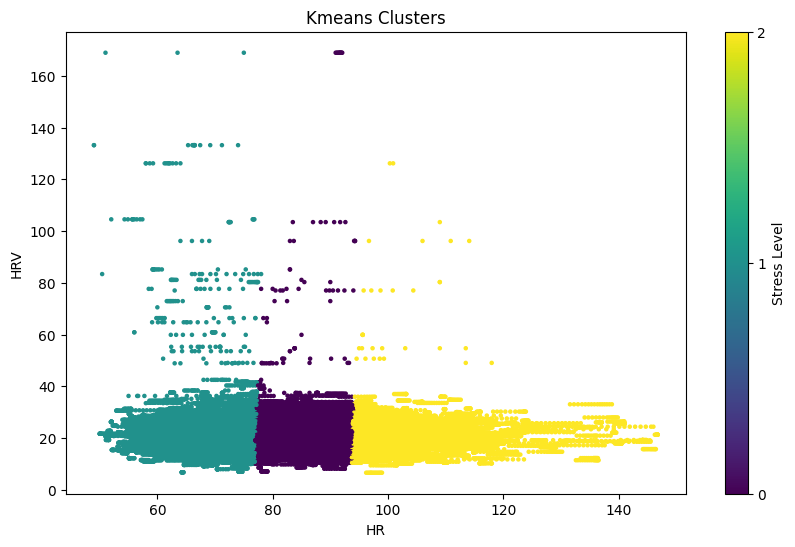

In [11]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['HRV', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['HRV'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [14]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'HRV']]
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
labels_predictions = data['stress_pred_rf'].map({0: 'low', 1: 'high'})

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.95      0.91      0.93     36815
         low       0.96      0.98      0.97     75656

    accuracy                           0.95    112471
   macro avg       0.95      0.94      0.95    112471
weighted avg       0.95      0.95      0.95    112471



## Deep Learning Approach